# Text Classification from Scratch

##**1. Setup Environment**

In [2]:
!pip install datasets -q

In [5]:
import os
import re
import time
import torch
import string
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
from datasets import load_dataset
from torch.nn import functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

In [6]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

print(f"Random seed set to {SEED}")

Random seed set to 42


##**2. Load Dataset**

In [7]:
ds = load_dataset("uitnlp/vietnamese_students_feedback")

README.md: 0.00B [00:00, ?B/s]

c:\Users\Learning\miniconda3\envs\torchenv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Learning\.cache\huggingface\hub\datasets--uitnlp--vietnamese_students_feedback. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vietnamese_students_feedback.py: 0.00B [00:00, ?B/s]

default/train/0000.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

default/validation/0000.parquet:   0%|          | 0.00/63.3k [00:00<?, ?B/s]

default/test/0000.parquet:   0%|          | 0.00/134k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11426 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1583 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3166 [00:00<?, ? examples/s]

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

##**3. Preprocessing**

### 3.1 Tokenizer & Vocabulary

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def basic_tokenizer(text):
    return text.lower().split()

In [69]:
class Vocabulary:
    def __init__(self, max_tokens=None, specials=None):
        self.max_tokens = max_tokens
        self.specials = specials if specials else []
        self.stoi = {}
        self.itos = {}
        self.default_index = 0

    def build_vocab(self, sentences, tokenizer):
        counter =Counter()
        for sentence in sentences:
            tokens = tokenizer(sentence)
            counter.update(tokens)
        #Giữ chỗ cho token đặc biệt <unk>, <pad>
        for idx, special in enumerate(self.specials):
            self.stoi[special] = idx
            self.itos[idx] = special
        print(self.stoi )
        print(self.itos)
        
        #cls -> most common token ->  giữ lại token xuất hiện nhiều nhất 
        #số lượng muốn giữ lại 
        keep_n= self.max_tokens - len(self.specials) if self.max_tokens else None
        most_common = counter.most_common(keep_n)
        print(len(most_common))
        #tạo bộ vocal để gán index cho token 
        for word, _ in most_common:
            if word not in self.stoi:
                idx= len(self.stoi)
                self.stoi[word] = idx
                self.itos[idx] = word
    
    def set_default_index(self, index):
        self.default_index = index   # out of vocab từ không thuộc vocab auto gán vào default index 
        # có ý nghĩa trong phần inference
    
    def __call__(self, tokens):
        ### COMPLETE THE CODE HERE
        return [self.stoi.get(token, self.default_index) for token in tokens]
    
    def __len__(self):
        return len(self.stoi)
    
    def __getitem__(self, token):
        return self.stoi.get(token, self.default_index)

In [70]:
vocab_size = 10000

### COMPLETE THE CODE HERE
vocabulary = Vocabulary(max_tokens=vocab_size, 
                        specials=["<unk>", "<pad>"])
vocabulary.build_vocab(ds["train"]["sentence"], tokenizer=basic_tokenizer)
vocabulary.set_default_index(vocabulary["<unk>"])

{'<unk>': 0, '<pad>': 1}
{0: '<unk>', 1: '<pad>'}
2514


In [71]:
print(f'Vocabulary size: {len(vocabulary)} \n')
for i in range(6):
    print(f'token: {vocabulary.itos[i]} \t index: {vocabulary.stoi[vocabulary.itos[i]]}')


print(f"token tôi có index là: {vocabulary['tôi']}")

Vocabulary size: 2516 

token: <unk> 	 index: 0
token: <pad> 	 index: 1
token: . 	 index: 2
token: , 	 index: 3
token: viên 	 index: 4
token: giảng 	 index: 5
token tôi có index là: 457


### 3.2 Tokenize Dataset

In [72]:
def prepare_dataset(sentences, labels, vocabulary, tokenizer):
    ### COMPLETE THE CODE HERE
    dataset = []
    for sentence, label in zip(sentences, labels):
        tokens = tokenizer(sentence)
        encoded_tokens = vocabulary(tokens)
        dataset.append((encoded_tokens, label))
    return dataset

### COMPLETE THE CODE HERE
train_dataset = prepare_dataset(ds["train"]["sentence"], ds["train"]["sentiment"], vocabulary, basic_tokenizer)
valid_dataset = prepare_dataset(ds["validation"]["sentence"], ds["validation"]["sentiment"], vocabulary, basic_tokenizer)
test_dataset = prepare_dataset(ds["test"]["sentence"], ds["test"]["sentiment"], vocabulary, basic_tokenizer)

In [73]:
print(train_dataset[0])

([123, 48, 54, 126, 94, 2], 2)


### 3.3 Dataloader

In [77]:
seq_length = 100
# Thực hiện padding và truncation text 
def collate_batch(batch):
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0] * (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [78]:
batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [79]:
next(iter(train_dataloader))

(tensor([[  7,  48,  67,  ...,   0,   0,   0],
         [  5,   4,  22,  ...,   0,   0,   0],
         [  5,   4,   5,  ...,   0,   0,   0],
         ...,
         [ 25, 204, 231,  ...,   0,   0,   0],
         [  5,   4, 127,  ...,   0,   0,   0],
         [ 12, 153,  30,  ...,   0,   0,   0]]),
 tensor([2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2,
         0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 2,
         0, 2, 2, 0, 0, 2, 0, 2, 1, 0, 1, 2, 0, 0, 2, 1]))

## **4. Modeling**

### 4.1 Token & Positional Embedding

In [80]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device="cpu"):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

### 4.2 Transformer Encoder Block

In [81]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.01):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        ### COMPLETE THE CODE HERE
        attn_output, _ = self.attn(query, key, value)
        attn_output =  self.dropout_1(attn_output)
        out_1 = self.layernorm_1(attn_output+ query)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(ffn_output + out_1)
        return out_2

### 4.3 Transformer Encoder

In [82]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim,
                 dropout=0.01, device="cpu"
        ):
        super().__init__()
        ### COMPLETE THE CODE HERE
        self.embedding = TokenAndPositionEmbedding(
            vocab_size=src_vocab_size,
            embed_dim=embed_dim,
            max_length=max_length,
            device=device
        )

        self.layers = nn.ModuleList([
            TransformerEncoderBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                dropout=dropout
            ) for i in range(num_layers)
        ])
    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

### 4.4 Transformer Encoder From Scratch

In [ ]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim,
                 dropout=0.01, device="cpu"
        ):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=30)
        self.fc2 = nn.Linear(in_features=30, out_features=3)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        ### COMPLETE THE CODE HERE
        output = self.encoder(x)
        output = self.pooling(output.permute(0,2, 1)).squeeze()
        output= self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

In [ ]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.01

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

##**5. Trainer**

In [85]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [86]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            ### COMPLETE THE CODE HERE
            inputs = inputs.to(device)  # Chuyển inputs lên device (GPU/CPU)
            labels = labels.to(device)  # Chuyển labels lên device

            predictions = model(inputs)  # Tính predictions từ model

            loss = criterion(predictions, labels)  # Tính loss
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()  # Đếm số dự đoán đúng
            total_count += labels.size(0)  # Đếm tổng số samples

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [87]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        "train_accuracy": train_accs,
        "train_loss": train_losses,
        "valid_accuracy": eval_accs,
        "valid_loss": eval_losses,
        "time": times
    }
    return model, metrics

In [88]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

##**6. Training**

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = "./model"
os.makedirs(save_model, exist_ok = True)
model_name = "model"

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  179 batches | accuracy    0.526
| epoch   1 |   100/  179 batches | accuracy    0.570
| epoch   1 |   150/  179 batches | accuracy    0.721
-----------------------------------------------------------
| End of epoch   1 | Time:  4.67s | Train Accuracy    0.782 | Train Loss    0.760 | Valid Accuracy    0.777 | Valid Loss    0.574 
-----------------------------------------------------------
| epoch   2 |    50/  179 batches | accuracy    0.793
| epoch   2 |   100/  179 batches | accuracy    0.831
| epoch   2 |   150/  179 batches | accuracy    0.839
-----------------------------------------------------------
| End of epoch   2 | Time:  4.66s | Train Accuracy    0.841 | Train Loss    0.473 | Valid Accuracy    0.855 | Valid Loss    0.425 
-----------------------------------------------------------
| epoch   3 |    50/  179 batches | accuracy    0.866
| epoch   3 |   100/  179 batches | accuracy    0.854
| epoch   3 |   150/  179 batches | accuracy    0.858
------------

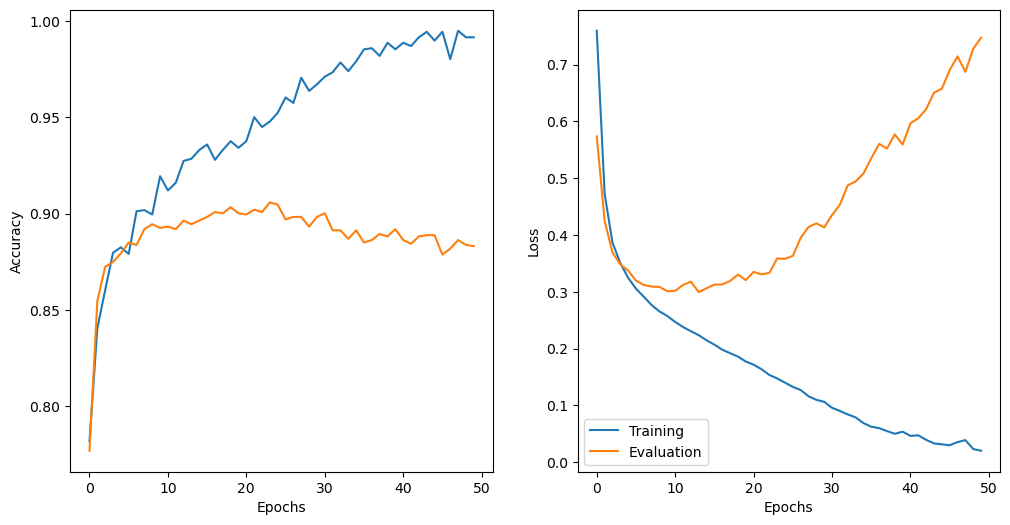

In [92]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

plt.savefig("text_scratch_result.pdf")
plt.savefig("text_scratch_result.png")

##**7. Evaluation**

In [93]:
train_acc, train_loss = evaluate_epoch(model, criterion, train_dataloader, device)
print(f"Train Set      - Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")

valid_acc, valid_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
print(f"Validation Set - Accuracy: {valid_acc:.4f}, Loss: {valid_loss:.4f}")

test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
print(f"Test Set       - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

Train Set      - Accuracy: 0.9971, Loss: 0.0143
Validation Set - Accuracy: 0.8831, Loss: 0.7474
Test Set       - Accuracy: 0.8557, Loss: 0.9017


In [94]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

label_names = ["Negative", "Neutral", "Positive"]
print(classification_report(all_labels, all_preds, target_names=label_names))

              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88      1409
     Neutral       0.34      0.26      0.30       167
    Positive       0.89      0.89      0.89      1590

    accuracy                           0.86      3166
   macro avg       0.70      0.68      0.69      3166
weighted avg       0.85      0.86      0.85      3166

